# Command Classification Using Recurrent Neural Nets (RNNs)



In [491]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

# Reproducibility
seed = 0
torch.manual_seed(0)
np.random.seed(0)

## Load Word Embeddings and Data

In [492]:
def load_embeddings(file_name, max_words=50000):
    """
    Read word vectors and create conversion dictionaries from a word embeddings file
    Optionally, you can change the number of maximum words to use
    """

    # Initialize the dictionaries with the unknown token
    word_to_ix = {"<UNK>": 0}
    ix_to_word = {0: "<UNK>"}
    vectors = [[]]

    # Go through all the words, get their embedding vectors, and add to the dictionaries
    with open(file_name,"r") as f:
        counter = 0
        for line in f.readlines():
            items = line.split()
            if counter < max_words:
                counter += 1
                word_to_ix[items[0]] = counter
                ix_to_word[counter] = items[0]
                vectors.append([float(x) for x in items[1:]])

        # Randomly set the weights of the first element mapping to "UNKNOWN"
        vector_len = len(vectors[-1])
        vectors[0] = [np.random.random() * 2.0 - 1.0
                        for _ in range(vector_len)]

    return np.array(vectors), word_to_ix, ix_to_word

def prepare_input_sequence(sentence, word_to_ix):
    """ Uses the word to index dictionary to create a sequence of vocabulary indices """
    
    # Convert sentence to lower case, remove punctuation, and split
    sentence = sentence.translate(str.maketrans("","", string.punctuation))
    seq = sentence.lower().split(" ")
    
    # Now convert to a word index
    indices = []
    for w in seq:
        try:
            idx = word_to_ix[w]
        except:
            idx = 0 # UNK token
        indices.append(idx)
    return indices

def prepare_target_sequence(seq, action_to_ix, room_to_ix, obj_to_ix):
    """
    Uses the output grounding target dictionaries to create a sequence of output indices
    """
    action_idxs = [action_to_ix[seq[0]]]
    room_idxs = [room_to_ix[seq[1]]]
    object_idxs = [obj_to_ix[seq[2]]]
    return action_idxs, room_idxs, object_idxs

glove_file = os.path.join("glove.6B", "glove.6B.100d.txt") # Modify this as needed
glove_vectors, w2i, i2w = load_embeddings(glove_file)

In [493]:
class GroundingDataset(Dataset):
    """ Language grounding dataset """

    def __init__(self, filename, word_to_ix, action_to_ix, room_to_ix, object_to_ix, transform=None):
        self.data = pd.read_table(filename, sep=",")
        self.word_to_ix = word_to_ix
        self.action_to_ix = action_to_ix
        self.room_to_ix = room_to_ix
        self.object_to_ix = object_to_ix

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.data.iloc[idx].to_dict()
        inp_seq = item["Sentence"]
        inp = prepare_input_sequence(inp_seq, self.word_to_ix)
        tgt_seq = (item["Action"], item["Room"], item["Object"])
        tgt = prepare_target_sequence(tgt_seq,
            self.action_to_ix, self.room_to_ix, self.object_to_ix)

        return torch.LongTensor(inp), torch.LongTensor(tgt)

    def get_sentence(self,idx):
        return self.data["Sentence"][idx]

def create_grounding_dict(grounding_list):
    """
    Creates a grounding dictionary from a list. For example:
        ["Find,"Go","Get","Store"]
    becomes
        {"Find":0, "Get":1, "Go":2, "Store":3}
    """

    idx = 0
    grounding_dict = {}
    for elem in grounding_list:
        grounding_dict[elem] = idx
        idx += 1

    return grounding_dict

def create_target_dictionaries(training_file):
    """
    Create dictionaries for all the outputs (targets) of the grounding network
    """

    # Read the training data and get sorted list of all the groundings
    data = pd.read_table(training_file,sep=",")
    action_list = sorted(set(data.Action))
    room_list = sorted(set(data.Room))
    object_list = sorted(set(data.Object))

    # Convert to dictionary that is compatible with the grounding model
    action_to_ix = create_grounding_dict(action_list)
    room_to_ix = create_grounding_dict(room_list)
    object_to_ix = create_grounding_dict(object_list)
    return action_to_ix, room_to_ix, object_to_ix

# Create the training and test datasets
training_file = os.path.join("data", "rnn_training_data.txt")
test_file = os.path.join("data", "rnn_test_data.txt")
act2i, room2i, obj2i = create_target_dictionaries(training_file)
training_data = GroundingDataset(training_file, w2i, act2i, room2i, obj2i)
test_data = GroundingDataset(test_file, w2i, act2i, room2i, obj2i)

# Get a random item
idx = np.random.randint(0, training_data.__len__())
print(training_data.get_sentence(idx))
print(training_data.__getitem__(idx))

get me some banana by the bedroom
(tensor([  170,   286,    78, 10706,    22,     1,  7093]), tensor([[1],
        [0],
        [1]]))


## Define Recurrent Neural Network (RNN) Architecture

Note that this will work only by passing individual inputs or batches of fixed-size sequences, as it makes the syntax simpler.

If you want to use batches of data with variable-size sequences, you may want to look at the pad_packed_sequence and pack_padded_sequence functions.

In [494]:
class GroundingNetwork(nn.Module):
    """Neural network for language grounding"""

    def __init__(self, action_size, room_size, object_size,
                 unit_type="rnn", hidden_dim=32, num_layers=2, 
                 emb_weights=glove_vectors, bidir=False, dropout=0.25):

        super().__init__()

        # Set dimension of hidden layer depending on LSTM directionality
        if bidir:
            self.hidden_dim = hidden_dim * 2
        else:
            self.hidden_dim = hidden_dim

        # Initialize word embeddings from the pretrained vectors and freeze the weights
        self.word_embeddings = nn.Embedding.from_pretrained(torch.Tensor(emb_weights), freeze=True)
        (_, embedding_dim) = emb_weights.shape

        # The RNN layers take word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.unit_type = unit_type
        if self.unit_type == "rnn":
            self.recurrent = nn.RNN(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir,
                                nonlinearity="tanh", dropout=dropout, 
                                batch_first=True)
        elif self.unit_type == "gru":
            self.recurrent = nn.GRU(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir,
                                dropout=dropout, batch_first=True)
        elif self.unit_type == "lstm":
            self.recurrent = nn.LSTM(embedding_dim, hidden_dim,
                                num_layers=num_layers, bidirectional=bidir, 
                                dropout=dropout, batch_first=True)
        
        # The linear layers that map from hidden state space to grounding space
        self.hidden2action = nn.Linear(self.hidden_dim, action_size)
        self.hidden2room = nn.Linear(self.hidden_dim, room_size)
        self.hidden2object = nn.Linear(self.hidden_dim, object_size)


    def forward(self, inp):

        # Embed the sentence
        embeds = self.word_embeddings(inp)

        # Pass through the LSTM Module
        rnn_out, _ = self.recurrent(embeds)

        # Grab the final RNN output for each batch element
        rnn_final = rnn_out[:,-1,:]

        # Final Fully Connected Networks
        action_scores = func.softmax(self.hidden2action(rnn_final), dim=1)
        room_scores = func.softmax(self.hidden2room(rnn_final), dim=1)
        object_scores = func.softmax(self.hidden2object(rnn_final), dim=1)

        return action_scores, room_scores, object_scores


# Create a sample network
net = GroundingNetwork(action_size=len(act2i), room_size=len(room2i), object_size=len(obj2i), 
                       unit_type="rnn", bidir=False)
print(net)


GroundingNetwork(
  (word_embeddings): Embedding(50001, 100)
  (recurrent): RNN(100, 32, num_layers=2, batch_first=True, dropout=0.25)
  (hidden2action): Linear(in_features=32, out_features=4, bias=True)
  (hidden2room): Linear(in_features=32, out_features=4, bias=True)
  (hidden2object): Linear(in_features=32, out_features=4, bias=True)
)


In [495]:
# Convert a sentence to a Torch Tensor of the word index sequence
test_sentence = "Go to the kitchen and find an apple."
test_sequence = prepare_input_sequence(test_sentence, w2i)
test_tensor = torch.LongTensor(test_sequence)
print("Sentence: {}".format(test_sentence))
print("Word Sequence: {}".format(test_embedded))
print("")

# Run inference using the randomly initialized weights
# (Everything should have ~equal probability since the model is not trained)
with torch.no_grad():
    act_scores, room_scores, obj_scores = net(test_tensor.view(1,-1))
print("Action scores: {}".format(act_scores.numpy()))
print("Room scores: {}".format(room_scores.numpy()))
print("Object scores: {}".format(obj_scores.numpy()))

Sentence: Go to the kitchen and find an apple.
Word Sequence: [243, 5, 1, 4907, 6, 597, 30, 3293]

Action scores: [[0.27299276 0.21096526 0.2631889  0.25285307]]
Room scores: [[0.23197006 0.31811956 0.23808897 0.21182136]]
Object scores: [[0.29734012 0.1590196  0.20281453 0.34082583]]


## Train a Network

Note that this will work only by passing individual inputs or batches with fixed-size sequences, as it makes the syntax simpler.

If you want to use batches of data with variable-size sequences, you may want to look at how to configure a DataLoader to collate batches using the pad_sequence function.

Epoch 1, Iteration 500, Average Loss -1.3583
Epoch 1, Iteration 1000, Average Loss -2.0303
Epoch 2, Iteration 1500, Average Loss -2.3636
Epoch 2, Iteration 2000, Average Loss -2.6680
Epoch 3, Iteration 2500, Average Loss -2.7627
Epoch 3, Iteration 3000, Average Loss -2.7993
Epoch 4, Iteration 3500, Average Loss -2.7609
Epoch 4, Iteration 4000, Average Loss -2.9515
Epoch 5, Iteration 4500, Average Loss -2.9084
Epoch 5, Iteration 5000, Average Loss -2.9706
Epoch 5, Iteration 5000, Average Loss -2.9720


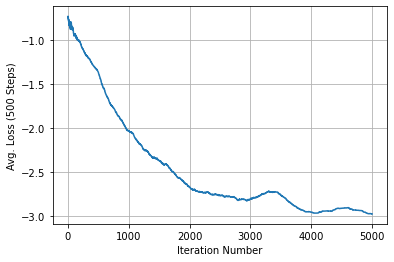

In [496]:
# Define a network
# Try changing these options to see their effect
net = GroundingNetwork(action_size=len(act2i), room_size=len(room2i), object_size=len(obj2i),
                       hidden_dim=32, num_layers=2, unit_type="lstm", bidir=True, dropout=0.25)
                       
# Learning parameters
NUM_EPOCHS = 5
LEARN_RATE = 0.005
ITER_WINDOW = 500
loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARN_RATE)
                             
# Training loop
i = 0
loss_window = deque(maxlen=ITER_WINDOW)
mean_losses = []
iter_ticks = []
for epoch in range(NUM_EPOCHS):
    for item in training_data:
        # Clear gradients
        net.zero_grad()

        # Run forward pass
        (inp, tgt) = item
        (action_scores, room_scores, object_scores) = net(inp.view(1,-1))
        
        action_targets = tgt[0]
        room_targets = tgt[1]
        object_targets = tgt[2]

        # Compute the loss, gradients, and update the parameters
        loss = loss_function(action_scores, action_targets) + \
               loss_function(room_scores, room_targets) + \
               loss_function(object_scores, object_targets)
        loss.backward()
        optimizer.step()

        # Add loss information for visualization
        i += 1
        loss_window.append(loss.detach().numpy())
        iter_ticks.append(i)
        mean_losses.append(np.mean(loss_window))
        if i % ITER_WINDOW == 0:
            print("Epoch {}, Iteration {}, Average Loss {:.4f}".format(epoch+1, i, mean_losses[-1]))

# Add loss information for the final iteration as well
loss_window.append(loss.detach().numpy())
iter_ticks.append(i)
mean_losses.append(np.mean(loss_window))
if i % ITER_WINDOW == 0:
    print("Epoch {}, Iteration {}, Average Loss {:.4f}".format(epoch+1, i, mean_losses[-1]))

# Plot the training results
plt.plot(iter_ticks, mean_losses)
plt.xlabel("Iteration Number")
plt.ylabel("Avg. Loss ({} Steps)".format(ITER_WINDOW))
plt.grid("on")
plt.show()

## Evaluate the Trained Network on the Test Set

In [497]:
def validate(net, data, word_to_ix, ix_to_word, action_to_ix, room_to_ix, object_to_ix, do_print=False):
    num_correct = 0
    idx = 0

    with torch.no_grad():
        for item in data:

            # Evaluate the model
            (inp, tgt) = item
            inp = inp.view(1,-1)
            (action_scores, room_scores, object_scores) = net(inp)

            # Find the max scores and predicted output
            tgt_list = tgt.tolist()                

            for i in range(action_scores.size()[0]):

                # Get predictions and indices
                _,act_ind = action_scores[i].max(0)
                _,room_ind = room_scores[i].max(0)
                _,obj_ind = object_scores[i].max(0)
                predicted_inds = (act_ind.item(),room_ind.item(),obj_ind.item())
                predicted_output = [list(action_to_ix)[predicted_inds[0]],
                                    list(room_to_ix)[predicted_inds[1]], 
                                    list(object_to_ix)[predicted_inds[2]]]
                
                # Get true grounding indices
                true_inds = (tgt_list[0][i],
                             tgt_list[1][i],
                             tgt_list[2][i])
                
                # Tally up the total number of correct predictions
                if predicted_inds == true_inds:
                    num_correct += 1

                # Print the output
                if do_print:
                    print("")
                    sentence = []
                    sentence_length = inp.shape[1]
                    for j in range(sentence_length):
                        elem = inp[i,j].item()
                        sentence.append(ix_to_word[elem])
                    print("Command: {}".format(" ".join(sentence)))
                    action_list = ["%.3f"%item for item in action_scores[i].tolist()]
                    print("Action scores: {}".format(action_list))
                    room_list = ["%.3f"%item for item in room_scores[i].tolist()]
                    print("Room scores: {}".format(room_list))
                    object_list = ["%.3f"%item for item in object_scores[i].tolist()]
                    print("Object scores: {}".format(object_list))
                    print("Prediction: {}".format(predicted_output))

                idx += 1

    return predicted_output, num_correct


# Calculate training and test accuracy
predicted_train,num_correct_train = validate(net, training_data, w2i, i2w, act2i, room2i, obj2i)
predicted_test, num_correct_test = validate(net, test_data, w2i, i2w, act2i, room2i, obj2i)
train_acc = 100*num_correct_train/len(training_data)
print("Training Accuracy = {}/{} ({:.2f}%)".format(num_correct_train, len(training_data), train_acc))
test_acc = 100*num_correct_test/len(test_data)
print("Test Accuracy = {}/{} ({:.2f}%)".format(num_correct_test, len(test_data), test_acc))

# Print on a few examples
num_samples = 5
sample_indices = np.random.choice(len(test_data), num_samples)
sample_data = [test_data.__getitem__(i) for i in sample_indices]
validate(net, sample_data, w2i, i2w, act2i, room2i, obj2i, do_print=True)

Training Accuracy = 1000/1000 (100.00%)
Test Accuracy = 498/500 (99.60%)

Command: drive near the beverage
Action scores: ['0.000', '0.000', '1.000', '0.000']
Room scores: ['0.000', '0.000', '0.000', '1.000']
Object scores: ['1.000', '0.000', '0.000', '0.000']
Prediction: ['go', 'unknown', 'drink']

Command: clear away the crackers close to the living room
Action scores: ['0.000', '0.000', '0.000', '1.000']
Room scores: ['0.000', '0.000', '1.000', '0.000']
Object scores: ['0.000', '0.000', '1.000', '0.000']
Prediction: ['store', 'living room', 'snack']

Command: locate some thing inside the sitting room
Action scores: ['1.000', '0.000', '0.000', '0.000']
Room scores: ['0.000', '0.000', '1.000', '0.000']
Object scores: ['0.000', '0.000', '0.000', '1.000']
Prediction: ['find', 'living room', 'unknown']

Command: grab some thing close to the my room
Action scores: ['0.000', '1.000', '0.000', '0.000']
Room scores: ['1.000', '0.000', '0.000', '0.000']
Object scores: ['0.000', '0.000', '0.00

(['store', 'living room', 'unknown'], 4)